## CZĘŚĆ 3: MODELOWANIE

1. Wczytanie danych, obróbka danych zgodnie z feature engineering

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import sklearn 

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.multioutput import ClassifierChain
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer

In [3]:
# Wczytanie danych - dane do trenowania modelu
development_unit_df = pd.read_csv(".\\dane\\training_sample_team4.csv")

## Ramka danych walidacyjna dla zespołu budującego
test = pd.read_csv(".\\dane\\validation_sample_team4.csv")

In [4]:
scaler = MinMaxScaler()
standard = StandardScaler()

zgodnie z wskazówkami, outliery zostały zastąpione wartościami granicznymi

In [5]:
def handle_outliers(df):
    columns_to_be_checked = ['r', 'u', 'i', 'z', 'g']
    
    df = df[df['u'] > 0]

    for i in range(len(columns_to_be_checked)):
        column = df[columns_to_be_checked[i]]
        Q1 = column.quantile(0.25)
        Q3 = column.quantile(0.75)

        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = (column < lower_bound) | (column > upper_bound)

        outliers_count = outliers.sum()

        outliers_percentage = outliers.mean() * 100
        
        # Zastąpienie outlierów wartościami równymi Q1 - 1.5 * IQR lub Q3 + 1.5 * IQR
        df.loc[outliers, columns_to_be_checked[i]] = np.where(column[outliers] < lower_bound, lower_bound, upper_bound)

        ##print("Ilość outlierów dla kolumny ", columns_to_be_checked[i], ": ", outliers_count)
        ##print("Procentowy udział outlierów dla kolumny ", columns_to_be_checked[i], ": ", outliers_percentage)

    return df

In [6]:
df = handle_outliers(development_unit_df)
test = handle_outliers(test)

dla przypomnienia:
###### usunięto kolumny silnie skorelowane
###### filtry w kolorze czerwieni zostały zsumowane i zawarte w jednej, nowej kolumnie (r + i + z)
###### końcowo, do tworzenia modeli użyto kolumn związanych z filtrami oraz kolumnę 'redshift' - uznano, że wszystkie zmienne związane z id lub z położeniem obiektów (kąty alpha i delta) nie wpływają na efektywność modelu
###### kolumny zostały zestandaryzowane i/lub znormalizowane


In [7]:
def modify_data(df):
    df = df.loc[:, df.columns != 'rerun_ID']
    df = df.loc[:, df.columns != 'obj_ID']
    df = df.loc[:, df.columns != 'plate']
    
    df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)

    # Normalizacja
    columns_to_normalize = ['run_ID', 'cam_col', 'spec_obj_ID', 'MJD', 'alpha', 'fiber_ID']
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    # Standaryzacja
    columns_to_standardize = ['delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'field_ID', 'r+i+z']
    df[columns_to_standardize] = standard.fit_transform(df[columns_to_standardize])

    # Usuwanie kolumn
    df = df.drop(['MJD'], axis = 1)
    df = df.drop(['r', 'i', 'z'], axis = 1)

    # Odrzucenie cech na podstawie interpretacji ich znaczenia
    df = df.drop(['spec_obj_ID'], axis = 1) # numer obiektu
    df = df.drop(['alpha'], axis = 1) # współrzędne astronomiczne
    df = df.drop(['delta'], axis = 1) # współrzędne astronomiczne
    df = df.drop(['field_ID'], axis = 1) # numer pola ze zdjęcia (fragment zdjęcia)
    df = df.drop(['cam_col'], axis = 1) # numer kolumny ze zdjęcia (fragment zdjęcia)
    df = df.drop(['run_ID'], axis = 1) # numer zdjęcia
    df = df.drop(['fiber_ID'], axis = 1) # numer włókna, które skierowało światło na płaszczyznę ogniskową
    
    return df

In [8]:
df = modify_data(development_unit_df)

In [9]:
df.head()

,u,g,class,redshift,r+i+z
0,0.678738,0.564729,QSO,2.408604,1.427677
1,-1.548889,-1.533804,GALAXY,-0.730359,-1.239177
2,-1.744904,-2.029105,STAR,-0.790164,-2.116429
3,-1.006758,-1.066027,GALAXY,-0.677478,-0.936643
4,-1.228689,-1.217197,GALAXY,-0.705030,-0.941500


In [10]:
test = modify_data(test)

In [11]:
test.head()

,u,g,class,redshift,r+i+z
0,0.695839,0.356947,QSO,2.206901,1.031172
1,0.181778,0.253523,GALAXY,-0.706093,0.985689
2,-0.366130,0.220645,QSO,2.013251,0.860169
3,0.756569,0.622013,STAR,-0.786839,-0.020183
4,0.764057,0.794126,GALAXY,-0.010139,0.314667


In [29]:
train = df.copy()
t = test.copy()


używane funkcje

In [30]:
def accuracy_fun(test_target, test_predictions):
    # Dokładność całkowita
    accuracy = accuracy_score(test_target, test_predictions)
    print("Dokładność całkowita (Accuracy):", accuracy)
    return accuracy

In [31]:
def raport(test_target, test_predictions):
    print("\nRaport klasyfikacji:")
    print(classification_report(test_target, test_predictions))

In [32]:
def matrix_confusion(test_target, test_predictions):
    print("\nConfusion matrix:")
    print(confusion_matrix(test_target, test_predictions))

In [33]:
def auc_gini(lb, test_target_bin, proba_predictions, test_target, model):
    auc_scores = []
    for i in range(len(lb.classes_)):
        auc_score = roc_auc_score(test_target_bin[:, i], proba_predictions[:, i])
        auc_scores.append(auc_score)
        print(f"AUC dla klasy {lb.classes_[i]}: {auc_score}")
        print(f"Gini dla klasy {lb.classes_[i]}: {2 * auc_score - 1}")
        print(" ")
        
        fpr, tpr, _ = roc_curve(test_target == model.classes_[i], proba_predictions[:, i])
        plt.plot(fpr, tpr, label=f'{model.classes_[i]} (AUC = {auc_score:.2f})')
    
    # Średni AUC
    mean_auc = np.mean(auc_scores)
    print("Średni AUC:", mean_auc)
    
    gini_coefficient = 2 * mean_auc - 1
    print("Gini coefficient:", gini_coefficient)
    return auc_scores, mean_auc, gini_coefficient

### 2. Modelowanie bez strojenia hiperparametrów: 
#### Użyto 7 modeli klasyfikacyjnych, następnie na podstawie ich predykcyjności wybrano modele do dalszej obróbki

Model 1 - KNeighboursClassifier

Dokładność całkowita (Accuracy): 0.9615238095238096

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.97      0.96      0.97     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.93      0.99      0.96      4489

    accuracy                           0.96     21000
   macro avg       0.95      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000


Confusion matrix:
[[12059   166   313]
 [  281  3687     5]
 [   40     3  4446]]
AUC dla klasy GALAXY: 0.9797728165653182
Gini dla klasy GALAXY: 0.9595456331306365
 
AUC dla klasy QSO: 0.978214195600062
Gini dla klasy QSO: 0.9564283912001239
 
AUC dla klasy STAR: 0.9939763724215583
Gini dla klasy STAR: 0.9879527448431167
 
Średni AUC: 0.9839877948623128
Gini coefficient: 0.9679755897246256


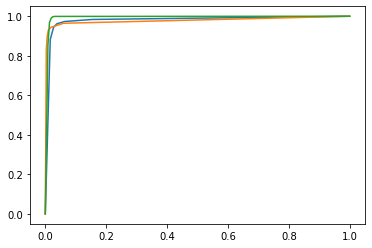

In [34]:
from sklearn.neighbors import KNeighborsClassifier

def evaluate_knn_model(train_data, train_target, test_data, test_target):
    # Inicjalizacja modelu KNN z domyślnymi parametrami
    knn_model = KNeighborsClassifier()
    
    # Trenowanie modelu na danych treningowych
    knn_model.fit(train_data, train_target)
    
    # Predykcja klas dla danych testowych
    test_predictions = knn_model.predict(test_data)
    
    # Accuracy
    accuracy = accuracy_fun(test_target, test_predictions)
    
    # Raport klasyfikacji
    raport(test_target, test_predictions)
    
    # Macierz pomyłek
    matrix_confusion(test_target, test_predictions)
    
    proba_predictions = knn_model.predict_proba(test_data)
    
    # Konwersja etykiet klas na formę binarną dla każdej klasy
    lb = LabelBinarizer()
    lb.fit(train_target)
    test_target_bin = lb.transform(test_target)
    
    # Obliczenie AUC dla każdej klasy
    auc_gini(lb, test_target_bin, proba_predictions, test_target, knn_model)
# Przykładowe dane
train_data = train.drop('class', axis=1)
train_target = train['class']
test_data = t.drop('class', axis=1)
test_target = t['class']
# Ocena modelu
evaluate_knn_model(train_data, train_target, test_data, test_target)


Model klasyfikacji KNN osiągnął ogólną dokładność na poziomie 96.15%. Z raportu klasyfikacji wynika, że model dobrze radzi sobie z klasyfikacją obiektów GALAXY oraz QSO, uzyskując odpowiednio 97% i 96% precyzji. Jednakże, dla klasy QSO (kwazarów) precyzja jest nieco niższa - 96%, co sugeruje, że model może mieć trudności w identyfikacji tej klasy.

Analiza macierzy pomyłek pokazuje, że model często myli klasy GALAXY z QSO, co może wymagać dalszej optymalizacji.

Średnie AUC dla każdej klasy oraz Gini coefficient wskazują, że model ma ogólnie dobrą zdolność do rozróżniania klas, z wynikami powyżej 0.95 dla każdej klasy.

Model 2 - RandomForestClassifier

Dokładność całkowita (Accuracy): 0.9635714285714285

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.98      0.97     12538
         QSO       0.95      0.93      0.94      3973
        STAR       0.98      0.96      0.97      4489

    accuracy                           0.96     21000
   macro avg       0.96      0.95      0.96     21000
weighted avg       0.96      0.96      0.96     21000


Confusion matrix:
[[12255   174   109]
 [  283  3689     1]
 [  198     0  4291]]
AUC dla klasy GALAXY: 0.9892064121289668
Gini dla klasy GALAXY: 0.9784128242579335
 
AUC dla klasy QSO: 0.9883353338032839
Gini dla klasy QSO: 0.9766706676065677
 
AUC dla klasy STAR: 0.9975750655250132
Gini dla klasy STAR: 0.9951501310500264
 
Średni AUC: 0.991705603819088
Gini coefficient: 0.983411207638176


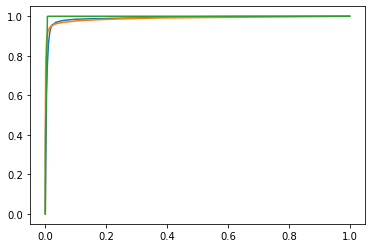

In [35]:
from sklearn.ensemble import RandomForestClassifier

def evaluate_forest_model(train_data, train_target, test_data, test_target):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    # Trenowanie modelu
    rf_model.fit(train_data, train_target)

    # Predykcja klas dla danych testowych
    test_predictions = rf_model.predict(test_data)
    
    # Accuracy
    accuracy = accuracy_fun(test_target, test_predictions)
    
    # Raport klasyfikacji
    raport(test_target, test_predictions)
    
    # Macierz pomyłek
    matrix_confusion(test_target, test_predictions)
    
    proba_predictions = rf_model.predict_proba(test_data)
    
    # Konwersja etykiet klas na formę binarną dla każdej klasy
    lb = LabelBinarizer()
    lb.fit(train_target)
    test_target_bin = lb.transform(test_target)
    
    # Obliczenie AUC dla każdej klasy
    auc_gini(lb, test_target_bin, proba_predictions, test_target, rf_model)

# Przykładowe dane
train_data = train.drop('class', axis=1)
train_target = train['class']
test_data = t.drop('class', axis=1)
test_target = t['class']
# Ocena modelu
evaluate_forest_model(train_data, train_target, test_data, test_target)

Model RandomForestClassifier osiągnął nieznacznie wyższą dokładność całkowitą w porównaniu do modelu KNN.
Wartości AUC dla klasy GALAXY i QSO są nieznacznie wyższe w przypadku drugiego modelu, podczas gdy dla klasy STAR wartość AUC jest zbliżona. Oznacza to, że RandomForestClassifier model ma lepszą zdolność do rozróżniania poszczególnych klas niż KNN

Model 3

xboost

In [41]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def evaluate_xboost_model(train_data, train_target, test_data, test_target):

    xgb_model = XGBClassifier(n_estimators=100, random_state=42)

    # Zakodowanie etykiet klas jako liczby
    label_encoder = LabelEncoder()
    train_target_encoded = label_encoder.fit_transform(train_target)
    test_target_encoded = label_encoder.transform(test_target)

    # Trenowanie modelu XGBoost
    xgb_model.fit(train_data, train_target_encoded)

    # Predykcja klas dla danych testowych
    test_predictions = xgb_model.predict(test_data)
    
    # Accuracy
    accuracy = accuracy_fun(test_target_encoded, test_predictions)
    
    # Raport klasyfikacji
    raport(test_target_encoded, test_predictions)
    
    # Macierz pomyłek
    matrix_confusion(test_target_encoded, test_predictions)
    
    proba_predictions = xgb_model.predict_proba(test_data)
    
    # Obliczenie AUC dla każdej klasy
    auc_scores = []
    for i in range(len(label_encoder.classes_)):
        auc_score = roc_auc_score(test_target_encoded == i, proba_predictions[:, i])
        auc_scores.append(auc_score)
        print(f"AUC dla klasy {label_encoder.classes_[i]}: {auc_score}")
        print(f"Gini dla klasy {label_encoder.classes_[i]}: {2 * auc_score - 1}")
        print(" ")
    
    # Średni AUC
    mean_auc = np.mean(auc_scores)
    print("Średni AUC:", mean_auc)
    
    gini_coefficient = 2 * mean_auc - 1
    print("Gini coefficient:", gini_coefficient)
    

# Przykładowe dane
train_data = train.drop('class', axis=1)
train_target = train['class']
test_data = t.drop('class', axis=1)
test_target = t['class']

# Ocena modelu
evaluate_xboost_model(train_data, train_target, test_data, test_target)

Dokładność całkowita (Accuracy): 0.9531428571428572

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     12538
           1       0.95      0.93      0.94      3973
           2       0.97      0.91      0.94      4489

    accuracy                           0.95     21000
   macro avg       0.96      0.94      0.95     21000
weighted avg       0.95      0.95      0.95     21000


Confusion matrix:
[[12243   188   107]
 [  287  3685     1]
 [  400     1  4088]]
AUC dla klasy GALAXY: 0.9888003244893265
Gini dla klasy GALAXY: 0.9776006489786531
 
AUC dla klasy QSO: 0.992220518097203
Gini dla klasy QSO: 0.984441036194406
 
AUC dla klasy STAR: 0.9966129494882066
Gini dla klasy STAR: 0.9932258989764131
 
Średni AUC: 0.9925445973582453
Gini coefficient: 0.9850891947164906


Model XGBoost poprawnie sklasyfikował 95.3% wszystkich próbek. Model osiągnął wysokie wartości precision dla wszystkich klas, co oznacza, że dobrze radził sobie zarówno z minimalizacją fałszywie pozytywnych jak i fałszywie negatywnych przypadków.
Model poprawnie zidentyfikował większość przypadków dla wszystkich klas, najwięcej błędów pojawiło się z klasyfikacją star i galaxy - model przewidział błędnie 400 razy klasę galaxy zamiast star.

Model 4

Gradient Boosting

Dokładność całkowita (Accuracy): 0.9655714285714285

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.98      0.97     12538
         QSO       0.96      0.91      0.94      3973
        STAR       0.98      0.97      0.97      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.96      0.96     21000
weighted avg       0.97      0.97      0.97     21000


Confusion matrix:
[[12275   154   109]
 [  341  3631     1]
 [  118     0  4371]]
AUC dla klasy GALAXY: 0.9888525363631973
Gini dla klasy GALAXY: 0.9777050727263945
 
AUC dla klasy QSO: 0.9912534571652245
Gini dla klasy QSO: 0.982506914330449
 
AUC dla klasy STAR: 0.9963079488553632
Gini dla klasy STAR: 0.9926158977107264
 
Średni AUC: 0.992137980794595
Gini coefficient: 0.9842759615891901


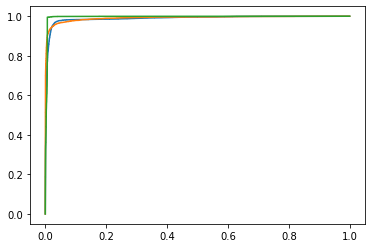

In [44]:
from sklearn.ensemble import GradientBoostingClassifier
def evaluate_gradient_model(train_data, train_target, test_data, test_target):

    gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

    # Trenowanie modelu Gradient Boosting
    gb_model.fit(train_data, train_target)


    # Predykcja klas dla danych testowych
    test_predictions = gb_model.predict(test_data)
    
    # Accuracy
    accuracy = accuracy_fun(test_target, test_predictions)
    
    # Raport klasyfikacji
    raport(test_target, test_predictions)
    
    # Macierz pomyłek
    matrix_confusion(test_target, test_predictions)
    
    proba_predictions = gb_model.predict_proba(test_data)
    
    # Konwersja etykiet klas na formę binarną dla każdej klasy
    lb = LabelBinarizer()
    lb.fit(train_target)
    test_target_bin = lb.transform(test_target)
    
    # Obliczenie AUC dla każdej klasy
    auc_gini(lb, test_target_bin, proba_predictions, test_target, gb_model)

# Przykładowe dane
train_data = train.drop('class', axis=1)
train_target = train['class']
test_data = t.drop('class', axis=1)
test_target = t['class']

# Ocena modelu
evaluate_gradient_model(train_data, train_target, test_data, test_target)

Model Gradient Boosting poprawnie sklasyfikował 96.6% wszystkich próbek.
Macierz pomyłek pokazuje, że model poprawnie rozróżnia klasy star i quasar (tylko jeden błąd)!

Podsumowując, zarówno model XGBoost, jak i Gradient Boosting wykazały się bardzo dobrymi wynikami, osiągając wysoką dokładność oraz skuteczność w klasyfikacji danych.

Model 5: Regresja logistyczna

Dokładność całkowita (Accuracy): 0.9533333333333334

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     12538
         QSO       0.94      0.88      0.91      3973
        STAR       0.94      1.00      0.97      4489

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.95      0.95      0.95     21000


Confusion matrix:
[[12053   205   280]
 [  490  3480     3]
 [    0     2  4487]]
AUC dla klasy GALAXY: 0.9830697143458644
Gini dla klasy GALAXY: 0.9661394286917289
 
AUC dla klasy QSO: 0.9850534243513777
Gini dla klasy QSO: 0.9701068487027553
 
AUC dla klasy STAR: 0.9956065121615257
Gini dla klasy STAR: 0.9912130243230515
 
Średni AUC: 0.9879098836195892
Gini coefficient: 0.9758197672391784


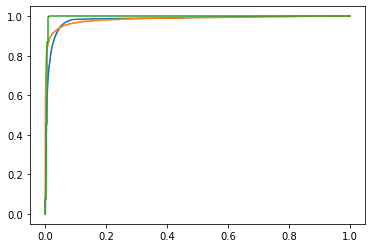

In [47]:
def evaluate_regression_model(train_data, train_target, test_data, test_target):

    log_reg_model = LogisticRegression(max_iter=1000, random_state=42)
    log_reg_model.fit(train_data, train_target)

    # Predykcja klas dla danych testowych
    test_predictions = log_reg_model.predict(test_data)
    
    # Accuracy
    accuracy = accuracy_fun(test_target, test_predictions)
    
    # Raport klasyfikacji
    raport(test_target, test_predictions)
    
    # Macierz pomyłek
    matrix_confusion(test_target, test_predictions)
    
    proba_predictions = log_reg_model.predict_proba(test_data)
    
    # Konwersja etykiet klas na formę binarną dla każdej klasy
    lb = LabelBinarizer()
    lb.fit(train_target)
    test_target_bin = lb.transform(test_target)
    
    # Obliczenie AUC dla każdej klasy
    auc_gini(lb, test_target_bin, proba_predictions, test_target, log_reg_model)

# Przykładowe dane
train_data = train.drop('class', axis=1)
train_target = train['class']
test_data = t.drop('class', axis=1)
test_target = t['class']

# Ocena modelu
evaluate_regression_model(train_data, train_target, test_data, test_target)

Model regresji logistycznej ma nieco niższą dokładność niż modele XGBoost i Gradient Boosting. Na razie najlepiej przewiduje klasę Star - prawie brak pomyłek w klasyfikowaniu star i quasar oraz nie zakwalifikował błędnie żadnej gwiazdy do galaktyki!

Model 6: Model Markova

In [50]:
def evaluate_markov_model(train_data, train_target, test_data, test_target):
    
    markov_model = ClassifierChain(base_estimator=DecisionTreeClassifier(), order='random', random_state=42)
    markov_model.fit(train_data, train_target)

    # Predykcja klas dla danych testowych
    test_predictions = markov_model.predict(test_data)
    
    # Accuracy
    accuracy = accuracy_fun(test_target, test_predictions)
    
    # Raport klasyfikacji
    raport(test_target, test_predictions)
    
    # Macierz pomyłek
    #matrix_confusion(test_target, test_predictions)
    proba_predictions = markov_model.predict_proba(test_data)
    
    # Konwersja etykiet klas na formę binarną dla każdej klasy
    lb = LabelBinarizer()
    lb.fit(train_target)
    test_target_bin = lb.transform(test_target)
    
    # Obliczenie AUC dla każdej klasy
    auc_scores = []
    for i in range(len(lb.classes_)):
        auc_score = roc_auc_score(test_target_bin[:, i], proba_predictions[:, i])
        auc_scores.append(auc_score)
        print(f"AUC dla klasy {lb.classes_[i]}: {auc_score}")
        print(f"Gini dla klasy {lb.classes_[i]}: {2 * auc_score - 1}")
        print(" ")
    
    # Średni AUC
    mean_auc = np.mean(auc_scores)
    print("Średni AUC:", mean_auc)
    
    gini_coefficient = 2 * mean_auc - 1
    print("Gini coefficient:", gini_coefficient)

# Przykładowe dane
train_data = train.drop('class', axis=1)
train_target = train['class']
test_data = t.drop('class', axis=1)
test_target = t['class']

# Zakodowanie klas za pomocą OneHotEncoder
encoder = OneHotEncoder(sparse=False)
train_target_encoded = encoder.fit_transform(train[['class']])
test_target_encoded = encoder.transform(t[['class']])

# Ocena modelu
evaluate_markov_model(train_data, train_target_encoded, test_data, test_target_encoded)

Dokładność całkowita (Accuracy): 0.8951904761904762

Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94     12538
           1       0.79      0.92      0.85      3973
           2       0.97      0.70      0.81      4489

   micro avg       0.90      0.90      0.90     21000
   macro avg       0.89      0.86      0.87     21000
weighted avg       0.90      0.90      0.89     21000
 samples avg       0.90      0.90      0.90     21000

AUC dla klasy 0: 0.9124776679838694
Gini dla klasy 0: 0.8249553359677388
 
AUC dla klasy 1: 0.9298596485932361
Gini dla klasy 1: 0.8597192971864722
 
AUC dla klasy 2: 0.8460061640457898
Gini dla klasy 2: 0.6920123280915795
 
Średni AUC: 0.8961144935409652
Gini coefficient: 0.7922289870819303


C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Markov Chain osiąga dobre wyniki, jednak w porówaniu z posostałymi modelami nie jest aż tak efektywny

Model 7

Adaptacyjne drzewa decyzyjne

Dokładność całkowita (Accuracy): 0.9145238095238095

Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.95      0.96      0.96     12538
         QSO       0.77      0.92      0.84      3973
        STAR       0.97      0.79      0.87      4489

    accuracy                           0.91     21000
   macro avg       0.90      0.89      0.89     21000
weighted avg       0.92      0.91      0.92     21000


Confusion matrix:
[[12017   420   101]
 [  326  3646     1]
 [  261   686  3542]]
AUC dla klasy GALAXY: 0.9445386898326842
Gini dla klasy GALAXY: 0.8890773796653684
 
AUC dla klasy QSO: 0.9263693893965154
Gini dla klasy QSO: 0.8527387787930307
 
AUC dla klasy STAR: 0.8914310877676357
Gini dla klasy STAR: 0.7828621755352714
 
Średni AUC: 0.9207797223322784
Gini coefficient: 0.8415594446645569


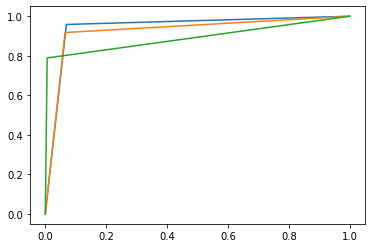

In [52]:
def evaluate_decisiontree_model(train_data, train_target, test_data, test_target):

    adtree_model = DecisionTreeClassifier()
    adtree_model.fit(train_data, train_target)

    # Predykcja klas dla danych testowych
    test_predictions = adtree_model.predict(test_data)
    
    # Accuracy
    accuracy = accuracy_fun(test_target, test_predictions)
    
    # Raport klasyfikacji
    raport(test_target, test_predictions)
    
    # Macierz pomyłek
    matrix_confusion(test_target, test_predictions)
    
    proba_predictions = adtree_model.predict_proba(test_data)
    
    # Konwersja etykiet klas na formę binarną dla każdej klasy
    lb = LabelBinarizer()
    lb.fit(train_target)
    test_target_bin = lb.transform(test_target)
    
    # Obliczenie AUC dla każdej klasy
    auc_gini(lb, test_target_bin, proba_predictions, test_target, adtree_model)

# Przykładowe dane
train_data = train.drop('class', axis=1)
train_target = train['class']
test_data = t.drop('class', axis=1)
test_target = t['class']

# Ocena modelu
evaluate_decisiontree_model(train_data, train_target, test_data, test_target)

Model DecisionTreeClassifier osiąga gorsze wyniki niż np. regresja logistyczna czy xgboost. Bardzo słabo przewiduje klasę STAR, co jest atutem pozostałych modeli.

#### wnioski:

1) najwyższa dokładność ogólna: knn, randomForest, gradient boosting ~ 0.96


2) najwyższa dokładność:


        dla Star: randomForest, gradient boosting ~ 0.98
        
        dla Galaxy: knn ~ 0.97
        
        dla Quasar: knn, gradient boosting ~ 0.96
        
        
3) najwyższy średni auc: gradient, boosting, xboost, randomForest  ~ 0.99


4) najwyższy auc:

        dla Star: wszystkie oprócz Markowa i DecisionTreeClassifier ~ 0.99
        
        dla Galaxy: wszystkie oprócz Markowa i DecisionTreeClassifier ~ 0.99
        
        dla Quasar: xboost, gradient boosting ~ 0.99


najsłabiej sobie radzi Model Markova

Decision Tree Classifier bardzo słabo przewiduję klasę STAR, dla każdego innego modelu predykcyjność STAR jest najwyższa, często bliska 100 %

### 3) Strojenie hiperparametrów dla wybranych modeli, wybór najlepszego

#### Do kolejnej części wybrano te modele, które osiągnęły najlepsze wyniki z standardowymi, niezmienionymi parametrami. Są to:

1) XGBoost

2) Random Forest Classifier

3) Logistic Regression ????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????????

In [59]:
from sklearn.model_selection import GridSearchCV

In [1]:
### strojenie parametrów forest

In [60]:
def hiperparams_forest(train_data, train_target, test_data, test_target):
    # Konwersja etykiet
    label_encoder = LabelEncoder()
    train_target_encoded = label_encoder.fit_transform(train_target)
    test_target_encoded = label_encoder.transform(test_target)

    rf_clf = RandomForestClassifier()

    # Definicja siatki parametrów do przeszukania
    param_grid = {
        'n_estimators': [50, 100, 150],  # Liczba drzew w lesie
        'max_depth': [None, 10, 20, 30],  # Maksymalna głębokość drzewa
        'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek wymagana do podziału węzła
        'min_samples_leaf': [1, 2, 4]  # Minimalna liczba próbek wymagana do utworzenia liścia
    }

    # Inicjalizacja GridSearchCV
    grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

    grid_search.fit(train_data, train_target_encoded)

    # Najlepsze parametry znalezione podczas strojenia
    best_params = grid_search.best_params_
    print("Najlepsze parametry:", best_params)

    # Uzyskanie najlepszego modelu po strojeniu
    best_rf_clf = grid_search.best_estimator_

    # Predykcja na danych testowych
    predictions = best_rf_clf.predict(test_data)
    
    # Dokładność
    accuracy = accuracy_score(test_target_encoded, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    class_names = label_encoder.classes_
    classification_rep = classification_report(test_target_encoded, predictions, target_names=class_names)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target_encoded, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)
    
    
    # AUC i Gini dla najlepszego modelu
    auc_scores = []
    gini_scores = []
    for class_name in class_names:
        class_index = label_encoder.transform([class_name])[0]
        class_probs = best_rf_clf.predict_proba(test_data)[:, class_index]
        class_target = (test_target_encoded == class_index).astype(int)
        auc = roc_auc_score(class_target, class_probs)
        auc_scores.append(auc)
        gini = 2 * auc - 1
        gini_scores.append(gini)
        print(f"AUC dla klasy '{class_name}': {auc}")
        print(f"Gini dla klasy '{class_name}': {gini}")

    # Średni AUC i Gini
    mean_auc = np.mean(auc_scores)
    mean_gini = np.mean(gini_scores)
    print(f"Średnie AUC: {mean_auc}")
    print(f"Średni Gini: {mean_gini}")
    

    return best_rf_clf, classification_rep, conf_matrix, mean_auc, mean_gini

In [61]:
best_rf_clf_forest, classification_rep_forest, conf_matrix_forest, mean_auc_forest, mean_gini_forest = hiperparams_forest(train_data, train_target, test_data, test_target)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Najlepsze parametry: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Dokładność: 0.9667142857142857
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.98      0.97      0.97      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.96      0.96     21000
weighted avg       0.97      0.97      0.97     21000

Confusion Matrix:
[[12261   167   110]
 [  288  3684     1]
 [  133     0  4356]]
AUC dla klasy 'GALAXY': 0.9903312507146791
Gini dla klasy 'GALAXY': 0.9806625014293582
AUC dla klasy 'QSO': 0.9904192525482285
Gini dla klasy 'QSO': 0.980838505096457
AUC dla klasy 'STAR': 0.9975656211101238
Gini dla klasy 'STAR': 0.9951312422202476
Średnie AUC: 0.9927720414576772
Średni Gini: 0.9855440829153542


In [65]:
def hiperparams_xgboost(train_data, train_target, test_data, test_target):
    # Konwersja etykiet
    label_encoder = LabelEncoder()
    train_target_encoded = label_encoder.fit_transform(train_target)
    test_target_encoded = label_encoder.transform(test_target)

    # Definicja modelu XGBoost
    xgb_clf = XGBClassifier()

    # Definicja siatki parametrów do przeszukania 
    param_grid = {
        'max_depth': [3, 6, 9],  # Maksymalna głębokość drzewa
        'learning_rate': [0.1, 0.3],  # Współczynnik uczenia
        'n_estimators': [50, 100],  # Liczba drzew
        'subsample': [0.8, 1.0],  # Procent próbek używanych do trenowania każdego drzewa
        'colsample_bytree': [0.8, 1.0],  # Procent kolumn używanych do trenowania każdego drzewa
    }

    # Inicjalizacja GridSearchCV
    grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

    # Dopasowanie modelu do danych treningowych
    grid_search.fit(train_data, train_target_encoded)

    # Najlepsze parametry znalezione podczas strojenia
    best_params = grid_search.best_params_
    print("Najlepsze parametry:", best_params)

    # Uzyskanie najlepszego modelu po strojeniu
    best_xgb_clf = grid_search.best_estimator_

    # Predykcja na danych testowych
    predictions = best_xgb_clf.predict(test_data)

    # Dokładność
    accuracy = accuracy_score(test_target_encoded, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    class_names = label_encoder.classes_
    classification_rep = classification_report(test_target_encoded, predictions, target_names=class_names)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target_encoded, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

     # AUC i Gini dla najlepszego modelu
    auc_scores = []
    gini_scores = []
    for class_name in class_names:
        class_index = label_encoder.transform([class_name])[0]
        class_probs = best_xgb_clf.predict_proba(test_data)[:, class_index]
        class_target = (test_target_encoded == class_index).astype(int)
        auc = roc_auc_score(class_target, class_probs)
        auc_scores.append(auc)
        gini = 2 * auc - 1
        gini_scores.append(gini)
        print(f"AUC dla klasy '{class_name}': {auc}")
        print(f"Gini dla klasy '{class_name}': {gini}")

    # Średni AUC i Gini
    mean_auc = np.mean(auc_scores)
    mean_gini = np.mean(gini_scores)
    print(f"Średnie AUC: {mean_auc}")
    print(f"Średni Gini: {mean_gini}")

    return best_xgb_clf, accuracy, classification_rep, conf_matrix, mean_auc, mean_gini


In [66]:
best_rf_clf_xgboost, classification_rep_xgboost, conf_matrix_xgboost, mean_auc_xgboost, mean_gini_xgboost = hiperparams_xgboost(train_data, train_target, test_data, test_target)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Najlepsze parametry: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.8}
Dokładność: 0.955047619047619
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.95      0.98      0.96     12538
         QSO       0.95      0.92      0.94      3973
        STAR       0.97      0.92      0.95      4489

    accuracy                           0.96     21000
   macro avg       0.96      0.94      0.95     21000
weighted avg       0.96      0.96      0.95     21000

Confusion Matrix:
[[12253   177   108]
 [  302  3670     1]
 [  356     0  4133]]
AUC dla klasy 'GALAXY': 0.9895612021562697
Gini dla klasy 'GALAXY': 0.9791224043125395
AUC dla klasy 'QSO': 0.9919983172962394
Gini dla klasy 'QSO': 0.9839966345924789
AUC dla klasy 'STAR': 0.9971775366102962
Gini dla klasy 'STAR': 0.9943550732205924
Średnie AUC: 0.9929123520209352
Średni Gini: 0.985

ValueError: too many values to unpack (expected 5)

In [60]:
# gradint boosting

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

def hiperparams_gradient_boosting(train_data, train_target, test_data, test_target):
    # Konwersja etykiet
    label_encoder = LabelEncoder()
    train_target_encoded = label_encoder.fit_transform(train_target)
    test_target_encoded = label_encoder.transform(test_target)

    # Definicja modelu Gradient Boosting
    gb_clf = GradientBoostingClassifier()

    # Definicja siatki parametrów do przeszukania
    param_grid = {
        'learning_rate': [0.1, 0.3],  # Współczynnik uczenia
        'n_estimators': [50, 100],  # Liczba estymatorów
        'max_depth': [3, 6],  # Maksymalna głębokość drzewa
        'min_samples_split': [2, 5, 10],  # Minimalna liczba próbek wymagana do podziału węzła
        'min_samples_leaf': [1, 2],  # Minimalna liczba próbek wymagana do utworzenia liścia
        'subsample': [0.8, 1.0],  # Procent próbek używanych do trenowania każdego estymatora
        'max_features': ['sqrt', 'log2']  # Maksymalna liczba cech branych pod uwagę przy podziale węzła
    }

    # Inicjalizacja GridSearchCV
    grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

    # Dopasowanie modelu do danych treningowych
    grid_search.fit(train_data, train_target_encoded)

    # Najlepsze parametry znalezione podczas strojenia
    best_params = grid_search.best_params_
    print("Najlepsze parametry:", best_params)

    # Uzyskanie najlepszego modelu po strojeniu
    best_gb_clf = grid_search.best_estimator_

    # Predykcja na danych testowych
    predictions = best_gb_clf.predict(test_data)

    # Dokładność
    accuracy = accuracy_score(test_target_encoded, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    class_names = label_encoder.classes_
    classification_rep = classification_report(test_target_encoded, predictions, target_names=class_names)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target_encoded, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    # AUC i Gini dla najlepszego modelu
    auc_scores = []
    gini_scores = []
    for class_name in class_names:
        class_index = label_encoder.transform([class_name])[0]
        class_probs = best_gb_clf.predict_proba(test_data)[:, class_index]
        class_target = (test_target_encoded == class_index).astype(int)
        auc = roc_auc_score(class_target, class_probs)
        auc_scores.append(auc)
        gini = 2 * auc - 1
        gini_scores.append(gini)
        print(f"AUC dla klasy '{class_name}': {auc}")
        print(f"Gini dla klasy '{class_name}': {gini}")

    # Średni AUC i Gini
    mean_auc = np.mean(auc_scores)
    mean_gini = np.mean(gini_scores)
    print(f"Średnie AUC: {mean_auc}")
    print(f"Średni Gini: {mean_gini}")

    return best_gb_clf, accuracy, classification_rep, conf_matrix, mean_auc, mean_gini


In [66]:
best_gb_clf_gradient, accuracy_gradient, classification_rep_gradient, conf_matrix_gradient, mean_auc_gradient, mean_gini_gradient = hiperparams_gradient_boosting(train_data, train_target, test_data, test_target)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
Najlepsze parametry: {'learning_rate': 0.1, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1.0}
Dokładność: 0.9608571428571429
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.98      0.97     12538
         QSO       0.95      0.93      0.94      3973
        STAR       0.97      0.95      0.96      4489

    accuracy                           0.96     21000
   macro avg       0.96      0.95      0.96     21000
weighted avg       0.96      0.96      0.96     21000

Confusion Matrix:
[[12246   183   109]
 [  289  3683     1]
 [  238     2  4249]]
AUC dla klasy 'GALAXY': 0.9908753777078306
Gini dla klasy 'GALAXY': 0.9817507554156613
AUC dla klasy 'QSO': 0.9925660184278767
Gini dla klasy 'QSO': 0.9851320368557535
AUC dla klasy 'STAR': 0.9976197510994615
Gini dla klasy 'STAR': 0.9952395021989231
Ś

In [67]:
def hiperparams_logistic_regression(train_data, train_target, test_data, test_target):
    # Konwersja etykiet
    label_encoder = LabelEncoder()
    train_target_encoded = label_encoder.fit_transform(train_target)
    test_target_encoded = label_encoder.transform(test_target)

    # Definicja modelu regresji logistycznej
    lr_clf = LogisticRegression(max_iter=1000)

    # Definicja siatki parametrów do przeszukania
    param_grid = {
        'C': [0.01, 0.1, 1.0, 10.0],  # Parametr regularyzacji
        'penalty': ['l1', 'l2'],  # Rodzaj normy regularyzacji
        'solver': ['liblinear', 'saga'],  # Algorytm optymalizacji
        'class_weight': [None, 'balanced']  # Wagi klas
    }

    # Inicjalizacja GridSearchCV
    grid_search = GridSearchCV(estimator=lr_clf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

    # Dopasowanie modelu do danych treningowych
    grid_search.fit(train_data, train_target_encoded)

    # Najlepsze parametry znalezione podczas strojenia
    best_params = grid_search.best_params_
    print("Najlepsze parametry:", best_params)

    # Uzyskanie najlepszego modelu po strojeniu
    best_lr_clf = grid_search.best_estimator_

    # Predykcja na danych testowych
    predictions = best_lr_clf.predict(test_data)

    # Dokładność
    accuracy = accuracy_score(test_target_encoded, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    class_names = label_encoder.classes_
    classification_rep = classification_report(test_target_encoded, predictions, target_names=class_names)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target_encoded, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    # AUC i Gini dla najlepszego modelu
    auc_scores = []
    gini_scores = []
    for class_name in class_names:
        class_index = label_encoder.transform([class_name])[0]
        class_probs = best_lr_clf.predict_proba(test_data)[:, class_index]
        class_target = (test_target_encoded == class_index).astype(int)
        auc = roc_auc_score(class_target, class_probs)
        auc_scores.append(auc)
        gini = 2 * auc - 1
        gini_scores.append(gini)
        print(f"AUC dla klasy '{class_name}': {auc}")
        print(f"Gini dla klasy '{class_name}': {gini}")

    # Średni AUC i Gini
    mean_auc = np.mean(auc_scores)
    mean_gini = np.mean(gini_scores)
    print(f"Średnie AUC: {mean_auc}")
    print(f"Średni Gini: {mean_gini}")

    return best_lr_clf, accuracy, classification_rep, conf_matrix, mean_auc, mean_gini


In [68]:
best_lr_clf_regression, accuracy_regression, classification_rep_regression, conf_matrix_regression, mean_auc_regression, mean_gini_regression = hiperparams_logistic_regression(train_data, train_target, test_data, test_target)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Najlepsze parametry: {'C': 10.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'saga'}
Dokładność: 0.9596666666666667
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.96      0.97      0.97     12538
         QSO       0.94      0.88      0.91      3973
        STAR       0.97      1.00      0.98      4489

    accuracy                           0.96     21000
   macro avg       0.96      0.95      0.95     21000
weighted avg       0.96      0.96      0.96     21000

Confusion Matrix:
[[12180   204   154]
 [  486  3486     1]
 [    0     2  4487]]
AUC dla klasy 'GALAXY': 0.9867062037338893
Gini dla klasy 'GALAXY': 0.9734124074677786
AUC dla klasy 'QSO': 0.9851610989436818
Gini dla klasy 'QSO': 0.9703221978873635
AUC dla klasy 'STAR': 0.9973462408442637
Gini dla klasy 'STAR': 0.9946924816885274
Średnie AUC: 0.9897378478406115
Średni Gini: 0.9794756956812232


C:\Users\HP\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [68]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
import xgboost as xgb

def ensemble_model(train_data, train_target, test_data, test_target):
    # Definicja modeli
    xgb_clf = xgb.XGBClassifier()
    rf_clf = RandomForestClassifier()
    lr_clf = LogisticRegression()

    # Definicja modelu ensemble
    ensemble_model = VotingClassifier(estimators=[
        ('xgb', xgb_clf),
        ('rf', rf_clf),
        ('lr', lr_clf)
    ], voting='hard')

    # Dopasowanie modelu do danych treningowych
    ensemble_model.fit(train_data, train_target)

    # Predykcja na danych testowych
    predictions = ensemble_model.predict(test_data)

    # Dokładność
    accuracy = accuracy_score(test_target, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    classification_rep = classification_report(test_target, predictions)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    return ensemble_model, accuracy, classification_rep, conf_matrix

# Przykładowe wywołanie
ensemble_model, accuracy, classification_rep, conf_matrix = ensemble_model(train_data, train_target, test_data, test_target)


Dokładność: 0.9676666666666667
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     12538
         QSO       0.96      0.93      0.94      3973
        STAR       0.98      0.98      0.98      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.96      0.96     21000
weighted avg       0.97      0.97      0.97     21000

Confusion Matrix:
[[12259   168   111]
 [  294  3678     1]
 [  105     0  4384]]


ensemble model - połączenie forest, xgb oraz regression

In [72]:
def ensemble_model(train_data, train_target, test_data, test_target):
    # Definicja modeli
    xgb_clf = xgb.XGBClassifier()
    rf_clf = RandomForestClassifier()
    lr_clf = LogisticRegression()

    # Definicja modelu ensemble
    ensemble_model = VotingClassifier(estimators=[
        ('xgb', xgb_clf),
        ('rf', rf_clf),
        ('lr', lr_clf)
    ], voting='hard')

    # Dopasowanie modelu do danych treningowych
    ensemble_model.fit(train_data, train_target)

    # Predykcja na danych testowych
    predictions = ensemble_model.predict(test_data)

    # Dokładność
    accuracy = accuracy_score(test_target, predictions)
    print("Dokładność:", accuracy)

    # Raport klasyfikacji
    classification_rep = classification_report(test_target, predictions)
    print("Raport klasyfikacji:")
    print(classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(test_target, predictions)
    print("Confusion Matrix:")
    print(conf_matrix)

    return ensemble_model, accuracy, classification_rep, conf_matrix

# Przykładowe wywołanie
ensemble_model, accuracy, classification_rep, conf_matrix = ensemble_model(train_data, train_target, test_data, test_target)


Dokładność: 0.9684761904761905
Raport klasyfikacji:
              precision    recall  f1-score   support

      GALAXY       0.97      0.98      0.97     12538
         QSO       0.95      0.93      0.94      3973
        STAR       0.97      0.98      0.98      4489

    accuracy                           0.97     21000
   macro avg       0.97      0.96      0.96     21000
weighted avg       0.97      0.97      0.97     21000

Confusion Matrix:
[[12249   176   113]
 [  288  3684     1]
 [   84     0  4405]]
